In [ ]:
import kagglehub
# Download dataset from Kaggle
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
print("Path to dataset files:", path)


100%|██████████| 2.29G/2.29G [01:04<00:00, 37.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define dataset paths
train_dir = os.path.join(path, "chest_xray/train")
val_dir = os.path.join(path, "chest_xray/val")
test_dir = os.path.join(path, "chest_xray/test")


In [ ]:
# Image data generators with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation and test data generators (no augmentation)
val_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Flow data from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

test_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
# Load InceptionV3 base model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze base model layers
base_model.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 150, 150, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 74, 74, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 74, 74, 32)     │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 74, 74, 32)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 72, 72, 32)     │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 72, 72, 32)     │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 72, 72, 32)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 72, 72, 64)     │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 72, 72, 64)     │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 72, 72, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 35, 35, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 35, 35, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 35, 35, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 35, 35, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 33, 33, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 33, 33, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 22,327,585 (85.17 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [ ]:
# Calculate steps per epoch and validation steps

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 100s 499ms/step - accuracy: 0.7739 - loss: 0.5430 - val_accuracy: 0.6875 - val_loss: 0.7853
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 71s 420ms/step - accuracy: 0.8850 - loss: 0.2633 - val_accuracy: 0.7500 - val_loss: 0.8159
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 84s 422ms/step - accuracy: 0.8980 - loss: 0.2658 - val_accuracy: 0.7500 - val_loss: 0.5732
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 81s 426ms/step - accuracy: 0.9075 - loss: 0.2363 - val_accuracy: 0.7500 - val_loss: 0.6762
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 72s 427ms/step - accuracy: 0.9016 - loss: 0.2371 - val_accuracy: 0.7500 - val_loss: 0.7396
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 82s 420ms/step - accuracy: 0.9097 - loss: 0.2233 - val_accuracy: 0.7500 - val_loss: 0.7309
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 82s 424ms/step - accuracy: 0.9080 - loss: 0.2157 - val_accuracy: 0.7500 - val_loss: 0.6359
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 82s 425ms/step - accuracy: 0.9128 - loss: 0.2155 - va

In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 252ms/step - accuracy: 0.7554 - loss: 0.6309
Test Accuracy: 84.29%


20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 325ms/step - accuracy: 0.7554 - loss: 0.6309
Test Accuracy: 84.29%
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 413ms/step
Precision: 0.8202
Recall: 0.9590
F1 Score: 0.8842
Confusion Matrix:
[[152  82]
 [ 16 374]]


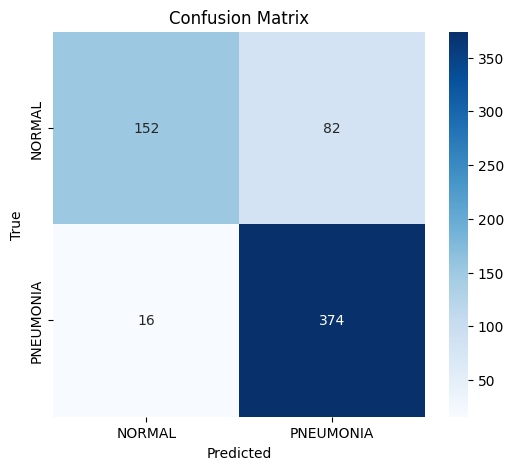

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Evaluate the model on the test data to get accuracy
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# 2. Get predictions from the model for the test set
test_generator.reset()  # Reset the generator to make sure we start from the beginning
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)

# Since the output is sigmoid (probability), we'll threshold it at 0.5 to get binary predictions
predictions_binary = (predictions > 0.5).astype("int32")

# 3. True labels
true_labels = test_generator.classes  # Get true labels from the generator

# 4. Calculate Precision, Recall, and F1 Score
precision = precision_score(true_labels, predictions_binary)
recall = recall_score(true_labels, predictions_binary)
f1 = f1_score(true_labels, predictions_binary)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# 5. Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predictions_binary)
print("Confusion Matrix:")
print(conf_matrix)

# 6. Plot Confusion Matrix using Seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


(-0.5, 149.5, 149.5, -0.5)

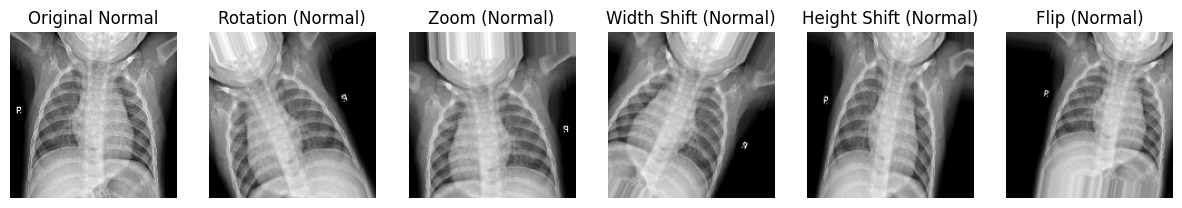

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths for 'NORMAL' and 'pneumonia' folders
normal_folder = os.path.join(train_dir, 'NORMAL')
pneumonia_folder = os.path.join(train_dir, 'PNEUMONIA')

# List all images in 'NORMAL' and 'pneumonia' folders
normal_images = os.listdir(normal_folder)
pneumonia_images = os.listdir(pneumonia_folder)

# Select one image randomly from each class
normal_image_path = os.path.join(normal_folder, random.choice(normal_images))
pneumonia_image_path = os.path.join(pneumonia_folder, random.choice(pneumonia_images))

# Load images using keras.preprocessing.image.load_img
normal_image = image.load_img(normal_image_path, target_size=(150, 150))
pneumonia_image = image.load_img(pneumonia_image_path, target_size=(150, 150))

# Convert images to numpy arrays
normal_image = image.img_to_array(normal_image) / 255.0
pneumonia_image = image.img_to_array(pneumonia_image) / 255.0

# Create an ImageDataGenerator for augmentations
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Apply augmentations to the images
normal_rotated = train_datagen.random_transform(normal_image)
pneumonia_rotated = train_datagen.random_transform(pneumonia_image)

normal_zoomed = train_datagen.random_transform(normal_image)
pneumonia_zoomed = train_datagen.random_transform(pneumonia_image)

normal_width_shift = train_datagen.random_transform(normal_image)
pneumonia_width_shift = train_datagen.random_transform(pneumonia_image)

normal_height_shift = train_datagen.random_transform(normal_image)
pneumonia_height_shift = train_datagen.random_transform(pneumonia_image)

normal_flipped = train_datagen.random_transform(normal_image)
pneumonia_flipped = train_datagen.random_transform(pneumonia_image)

# Plotting the images
plt.figure(figsize=(15, 10))

# Plot for NORMAL class
plt.subplot(2, 6, 1)
plt.imshow(normal_image)
plt.title('Original Normal')
plt.axis('off')

plt.subplot(2, 6, 2)
plt.imshow(normal_rotated)
plt.title('Rotation (Normal)')
plt.axis('off')

plt.subplot(2, 6, 3)
plt.imshow(normal_zoomed)
plt.title('Zoom (Normal)')
plt.axis('off')

plt.subplot(2, 6, 4)
plt.imshow(normal_width_shift)
plt.title('Width Shift (Normal)')
plt.axis('off')

plt.subplot(2, 6, 5)
plt.imshow(normal_height_shift)
plt.title('Height Shift (Normal)')
plt.axis('off')

plt.subplot(2, 6, 6)
plt.imshow(normal_flipped)
plt.title('Flip (Normal)')
plt.axis('off')

